In [1]:
%matplotlib inline
import network.network as Network
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

In [3]:
def predict1(n):
    # Get the data from the test set
    #x = test_data[n][0]
    x = test_images[n]
    # x = test_inputs[n]

    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.train.cls = np.argmax(data.train.labels, axis=1)

In [7]:
train_images = [np.reshape(x, (784, 1)) for x in data.train.images]
test_images = [np.reshape(x, (784, 1)) for x in data.test.images]

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


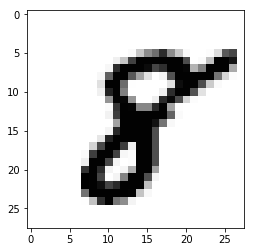

In [13]:
predict1(8384)

In [15]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [16]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

In [17]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while data.test.cls[idx] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, test_images[idx], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_images[idx].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

In [18]:
from collections import defaultdict

def euclidean_distance(img_a, img_b):
    '''Finds the distance between 2 images: img_a, img_b'''
    # element-wise computations are automatically handled by numpy
    return sum((img_a - img_b) ** 2)

def find_majority(labels):
    '''Finds the majority class/label out of the given labels'''
    # defaultdict(type) is to automatically add new keys without throwing error.
    counter = defaultdict(int)
    for label in labels:
        counter[label] += 1

    # Finding the majority class.
    majority_count = max(counter.values())
    for key, value in counter.items():
        if value == majority_count:
            return key      
        
def predict(k, train_images, train_labels, test_image):
    '''
    Predicts the new data-point's category/label by 
    looking at all other training labels
    '''
    # distances contains tuples of (distance, label)
    distances = [(euclidean_distance(test_image, image), label)
                    for (image, label) in zip(train_images, train_labels)]
    # sort the distances list by distances
    #print(distances)
    by_distances = sorted(distances, key=lambda distance: distance[0])
    #print(by_distances)
    # extract only k closest labels
    k_labels = [label for (_, label) in by_distances[:k]]
    # return the majority voted label
    return find_majority(k_labels)



What we want our adversarial example to look like: 


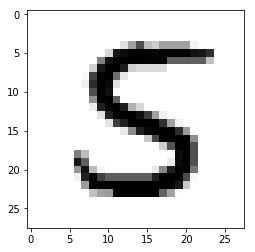



Adversarial Example: 


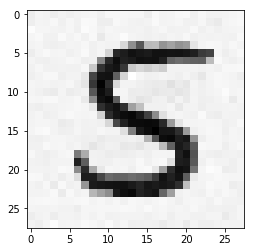

Network Prediction: 8

Network Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]



In [19]:
# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(8, 5)

In [20]:
pred = predict(10, train_images, data.train.cls, adv_ex)
print(pred)

5


In [42]:
def predict_ADV(k, train_images, train_labels, test_image):
    '''
    Predicts the new data-point's category/label by 
    looking at all other training labels
    '''
    # distances contains tuples of (distance, label)
    distances = [(euclidean_distance(test_image, image), label)
                    for (image, label) in zip(train_images, train_labels)]
    # sort the distances list by distances
    #print(distances)
    by_distances = sorted(distances, key=lambda distance: distance[0])
    #print(by_distances)
    # extract only k closest labels
    k_labels = [label for (_, label) in by_distances[:k]]
    # return the majority voted label
    predicted_label = find_majority(k_labels)
    predicted_image = train_images[np.where(train_labels == predicted_label)[0][0]]
    return predicted_image


In [46]:
def sneaky_generate_ADV(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while data.test.cls[idx] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, test_images[idx], 100, 1)
    pred = predict_ADV(10, train_images, data.train.cls, a)
    x = np.round(net.feedforward(pred), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_images[idx].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a


What we want our adversarial example to look like: 


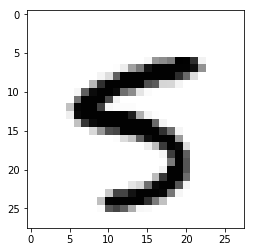



Adversarial Example: 


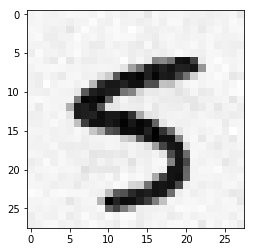

Network Prediction: 5

Network Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]



In [47]:
adv_ex = sneaky_generate_ADV(8, 5)